
🔍 Processing: Missing_hole

🔍 Processing: Mouse_bite

🔍 Processing: Open_circuit

🔍 Processing: Short

🔍 Processing: Spur

🔍 Processing: Spurious_copper


✅ TOTAL ROIs Extracted: 3198


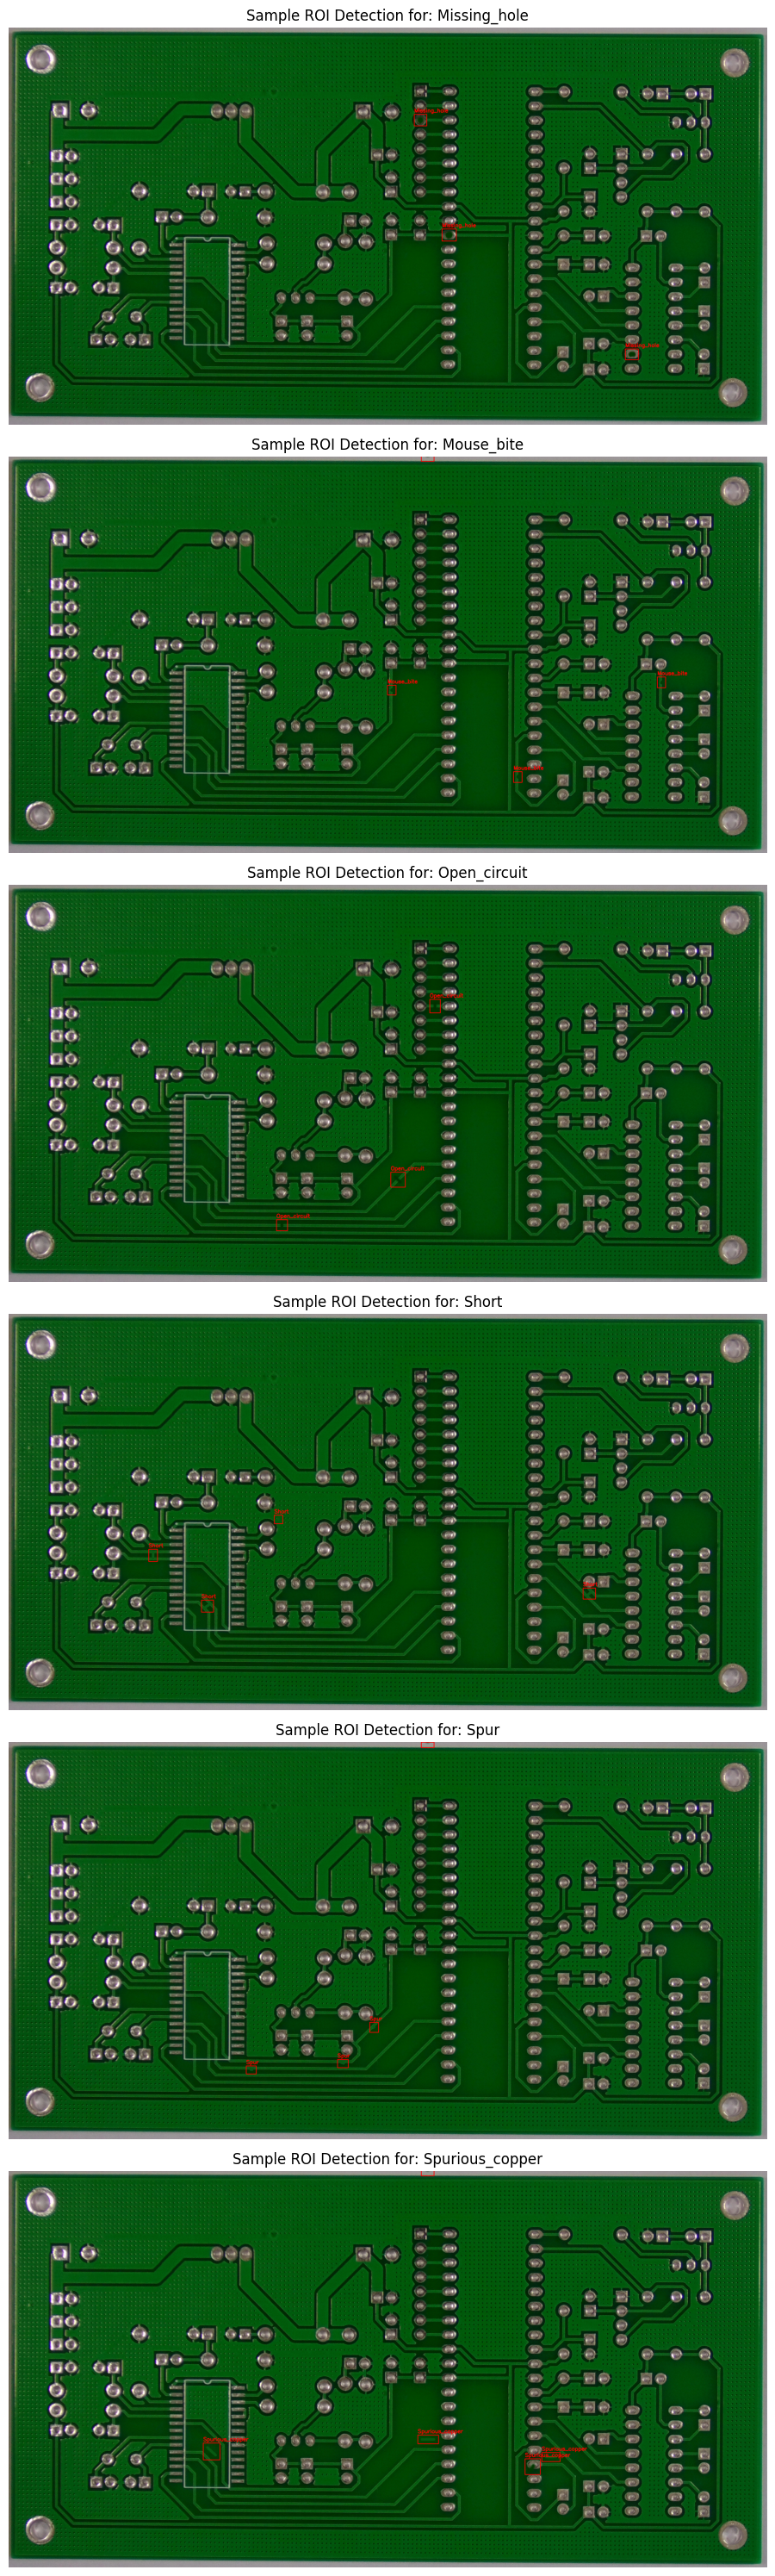


ROIs saved in: C:\Users\Kandu\OneDrive\Desktop\PCB_DATASET\ROIs


In [8]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt


# ============================================
# PATHS 
# ============================================
ROOT_DIR = r"C:\Users\Kandu\OneDrive\Desktop\PCB_DATASET"

INPUT_MASKS_DIR = os.path.join(ROOT_DIR, "masks_cleaned")       # From Module 1
ORIGINAL_IMAGES_DIR = os.path.join(ROOT_DIR, "images")          # Original images
OUTPUT_ROIS_DIR = os.path.join(ROOT_DIR, "ROIs")                # Module 2 output
os.makedirs(OUTPUT_ROIS_DIR, exist_ok=True)


# ============================================
# CONSTANTS
# ============================================
TARGET_SIZE = (128, 128)          # ROI size for EfficientNet
MIN_DEFECT_AREA = 40              # Filters noise contours

DEFECT_TYPES = [
    'Missing_hole',
    'Mouse_bite',
    'Open_circuit',
    'Short',
    'Spur',
    'Spurious_copper'
]


# ============================================
# HELPER: Find original image even if extension differs
# ============================================
def find_original_image(defect_type, base_name):
    search_dir = os.path.join(ORIGINAL_IMAGES_DIR, defect_type)

    for ext in [".jpg", ".JPG", ".png", ".PNG"]:
        candidate = os.path.join(search_dir, base_name + ext)
        if os.path.exists(candidate):
            return candidate
    
    return None  # Not found


# ============================================
# MAIN ROI EXTRACTION FUNCTION
# ============================================
def extract_and_save_rois(mask_path, original_img_path, defect_label):

    mask = cv2.imread(mask_path, 0)
    original_img = cv2.imread(original_img_path)

    if mask is None or original_img is None:
        return 0, None

    # Find contours
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    save_dir = os.path.join(OUTPUT_ROIS_DIR, defect_label)
    os.makedirs(save_dir, exist_ok=True)

    roi_count = 0
    viz_image = original_img.copy()

    for i, contour in enumerate(contours):

        # Skip tiny noise contours
        if cv2.contourArea(contour) < MIN_DEFECT_AREA:
            continue

        x, y, w, h = cv2.boundingRect(contour)

        # Padding for better ROI context
        padding = 12
        x1 = max(0, x - padding)
        y1 = max(0, y - padding)
        x2 = min(original_img.shape[1], x + w + padding)
        y2 = min(original_img.shape[0], y + h + padding)

        cropped_roi = original_img[y1:y2, x1:x2]

        # Invalid crop skip
        if cropped_roi.size == 0:
            continue

        # Resize for EfficientNet / YOLO classification
        final_roi = cv2.resize(cropped_roi, TARGET_SIZE, interpolation=cv2.INTER_LINEAR)

        # Save ROI
        roi_filename = f"{defect_label}_{os.path.basename(original_img_path).split('.')[0]}_{i}.png"
        cv2.imwrite(os.path.join(save_dir, roi_filename), final_roi)

        roi_count += 1

        # Draw contour on visualization
        cv2.rectangle(viz_image, (x1, y1), (x2, y2), (0, 0, 255), 2)
        cv2.putText(viz_image, defect_label, (x1, y1 - 8), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

    return roi_count, viz_image



# ============================================
# PROCESS ALL DEFECT CATEGORIES
# ============================================
total_rois_extracted = 0
sample_visualizations = []

for defect_type in DEFECT_TYPES:
    print(f"\n🔍 Processing: {defect_type}")

    mask_dir = os.path.join(INPUT_MASKS_DIR, defect_type)
    mask_files = [f for f in os.listdir(mask_dir) if f.endswith('.png')]

    for mask_filename in mask_files:

        # Remove "MASK_" prefix → get base name
        base_name = mask_filename.replace("MASK_", "").replace(".png", "")

        original_img_path = find_original_image(defect_type, base_name)
        mask_path = os.path.join(mask_dir, mask_filename)

        if original_img_path is None:
            print("❌ Could not find original for:", base_name)
            continue

        extracted, viz_img = extract_and_save_rois(mask_path, original_img_path, defect_type)
        total_rois_extracted += extracted

        if extracted > 0 and all(defect_type not in s for s, _ in sample_visualizations):
            sample_visualizations.append((defect_type, viz_img))

print(f"\n\n✅ TOTAL ROIs Extracted: {total_rois_extracted}")



# ============================================
# VISUALIZATION
# ============================================
num_samples = len(sample_visualizations)
plt.figure(figsize=(20, 5 * num_samples))

for i, (label, image) in enumerate(sample_visualizations):
    plt.subplot(num_samples, 1, i + 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(f"Sample ROI Detection for: {label}")
    plt.axis('off')

plt.tight_layout()
plt.show()

print(f"\nROIs saved in: {OUTPUT_ROIS_DIR}")
